<H1>Notebook for Optic Disc Localization and detection of Exudates using the IDRID Segmentation dataset</H1>

[![dataset](https://img.shields.io/badge/Open_in_Colab-orange)](https://githubtocolab.com/Sohambasu07/DR_2021/blob/master/notebooks/Blood_Vessel_Segmentation_DRIVE_dataset.ipynb)
[![paper](https://img.shields.io/badge/Springer-Full_Paper-blue)](https://doi.org/10.1007/978-981-16-1543-6_16)
[![dataset](https://img.shields.io/badge/IDRID-Dataset-yellow)](https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid#files)

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
import time
import os
from skimage import data
from skimage import filters
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import io, morphology
from skimage.morphology import disk
from skimage.filters.rank import entropy
from sklearn.metrics import confusion_matrix

cv.__version__

'4.8.0'

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#Setting filepaths

template_path = '' # path to save generated template for OD localization
directory_path = '' # path where images are stored
save_path = '' # path to save OD localization results

if os.path.exists(save_path) is False:
  os.mkdir(save_path)

In [ ]:
#Template creation
template = np.ones((95,95), dtype="uint8") * 0
template = cv.circle(template, (47,47), 46, 255, -1)
print(template)
plt.imshow(template, cmap = 'gray', interpolation = 'bicubic')
cv.imwrite(template_path, template)

In [ ]:
def getImage(img_num):
  path = directory_path
  str_num = str(img_num)
  if (img_num) < 10:
    str_num = '0'+ str_num
  name = 'IDRiD_' + str_num + '.jpg'
  full_path = path + name
  image = cv.imread(full_path, -1)
  print(full_path)
  return image

In [ ]:
def imgResize(img):
  h = img.shape[0]
  w = img.shape[1]
  perc = 500/w
  w1 = 500
  h1 = int(h*perc)
  img_rs = cv.resize(img,(w1,h1))
  return img_rs

In [ ]:
def cannyEdges(img, th1, th2):
  edges = cv.Canny(img, th1, th2)
  return edges

In [ ]:
def kmeansclust(img, k, attempts, max_iter, acc, use = 'OD'):

  if use == 'OD':
    img_rsp = img.reshape((-1,1))
  else :
    img_rsp = img.reshape((-1,3))

  img_rsp = img_rsp.astype('float32')


  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, acc)
  _, labels, (centers) = cv.kmeans(img_rsp, k, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)
  centers = centers.astype('uint8')

  labels = labels.flatten()
  seg_img = centers[labels.flatten()]
  seg_img = seg_img.reshape(img.shape)
  return seg_img

/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_01.jpg
Image Number:  1
362 158
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_02.jpg
Image Number:  2
90 145
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_03.jpg
Image Number:  3
83 165
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_04.jpg
Image Number:  4
227 96
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_05.jpg
Image Number:  5
340 157
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_06.jpg
Image Number:  6
322 160
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_07.jpg
Image Number:  7
354 190
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Image

<ipython-input-65-8c711ef0045a>:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(img_num)


/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_22.jpg
Image Number:  22
336 180
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_23.jpg
Image Number:  23
316 164
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_24.jpg
Image Number:  24
143 156
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_25.jpg
Image Number:  25
131 159
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_26.jpg
Image Number:  26
117 159
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_27.jpg
Image Number:  27
367 157
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_28.jpg
Image Number:  28
141 161
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Orig

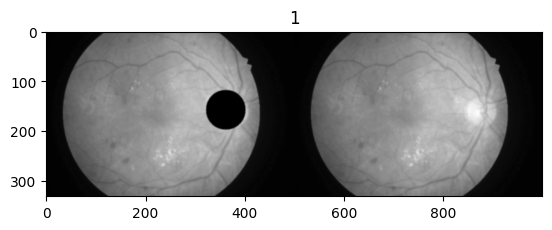

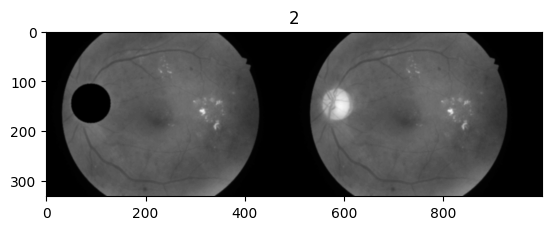

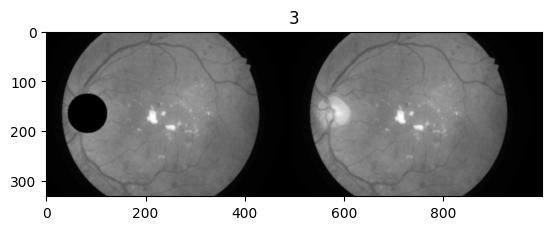

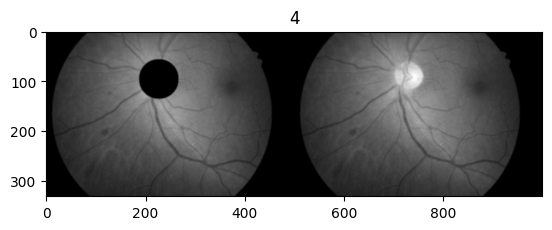

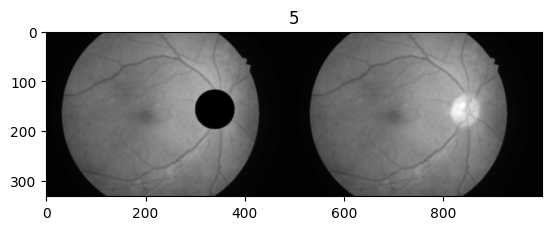

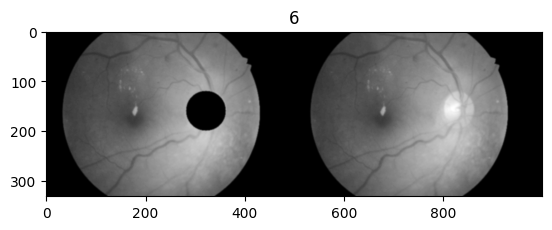

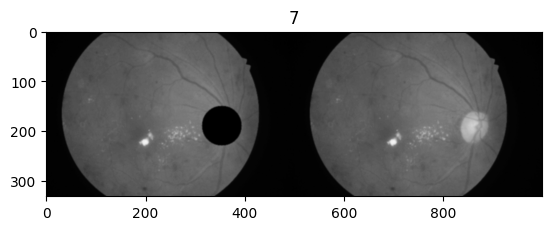

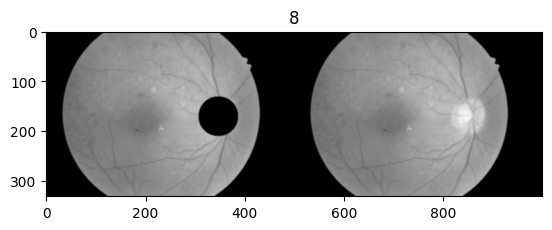

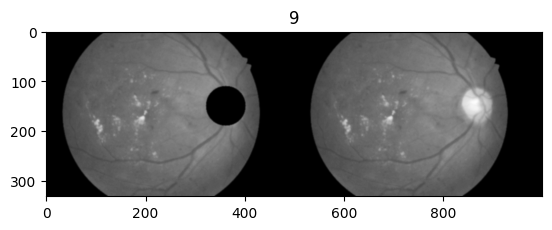

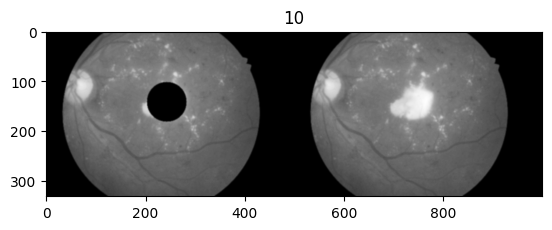

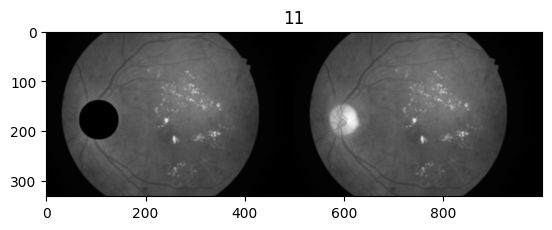

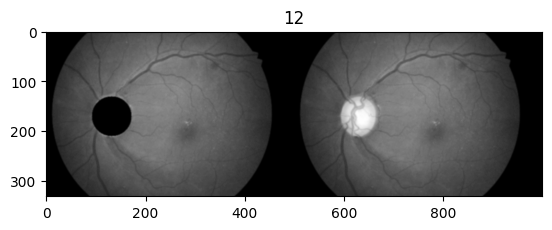

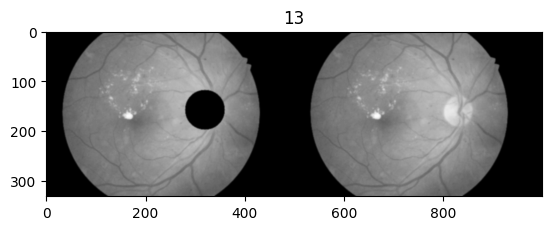

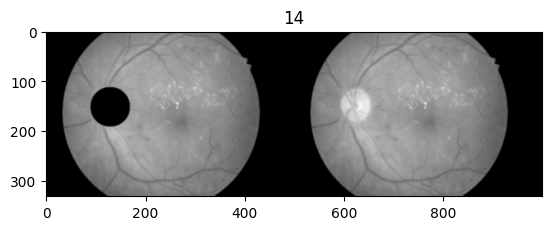

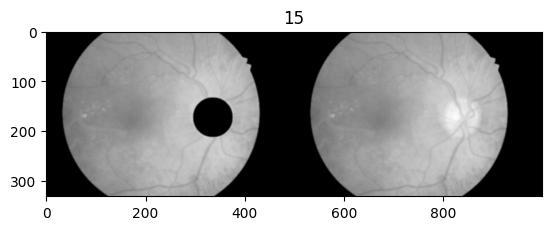

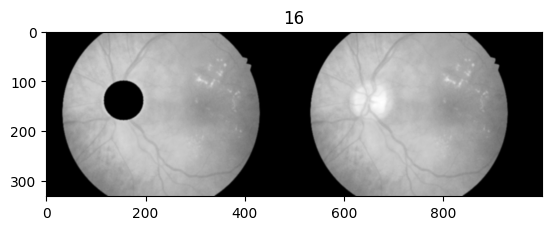

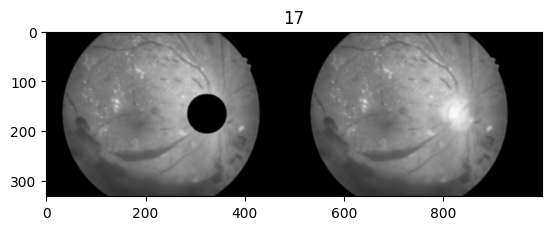

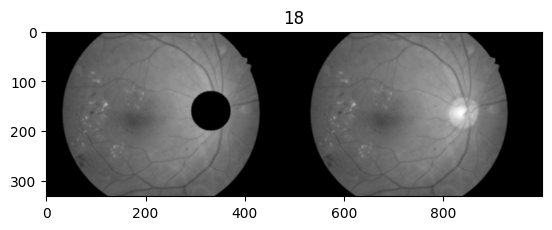

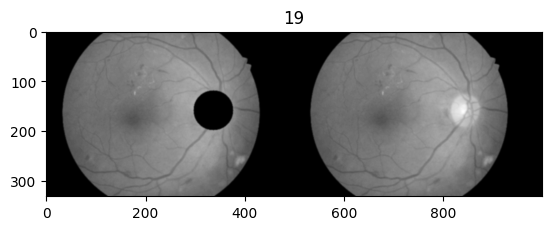

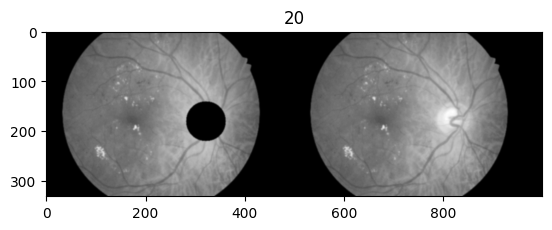

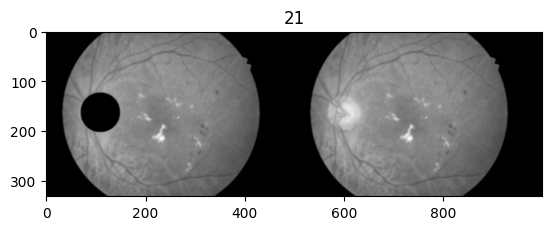

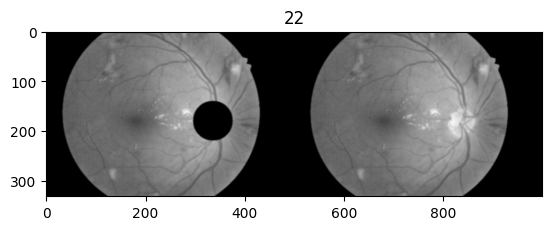

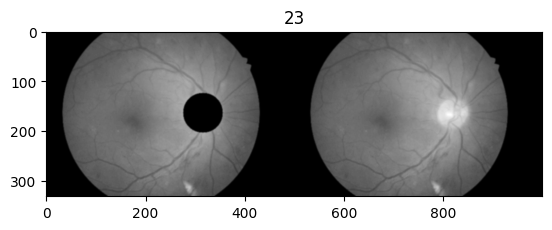

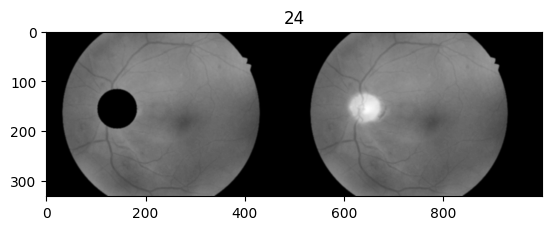

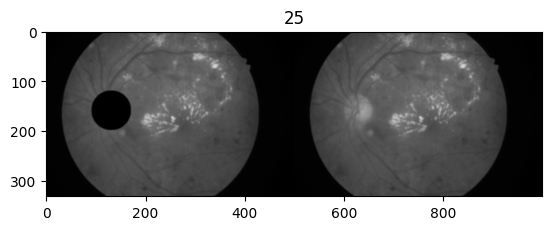

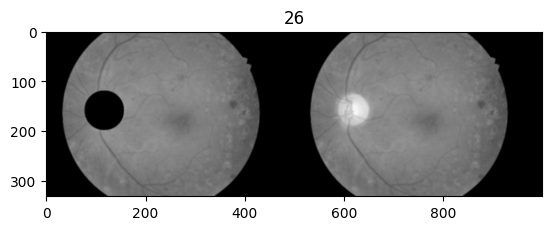

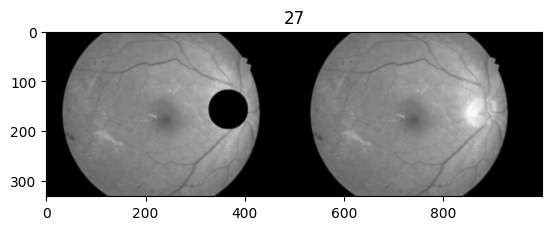

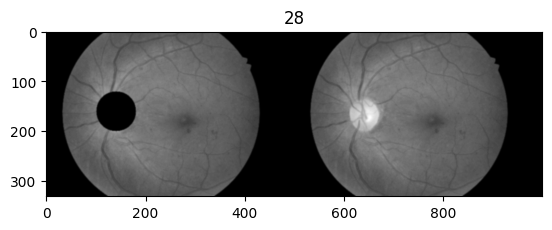

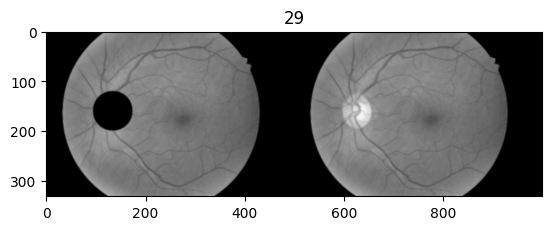

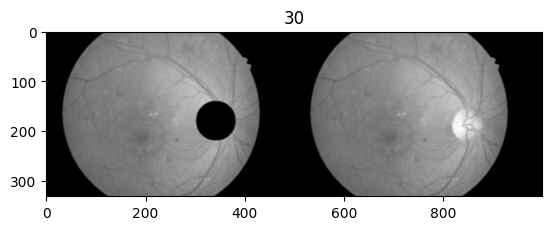

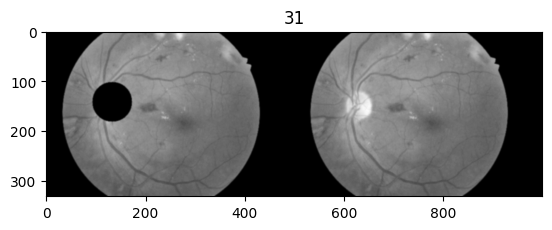

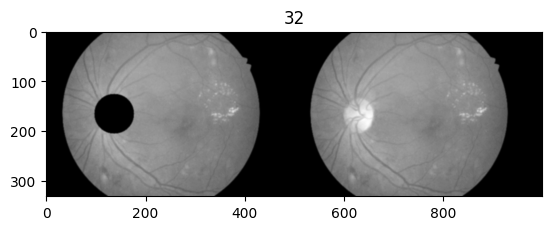

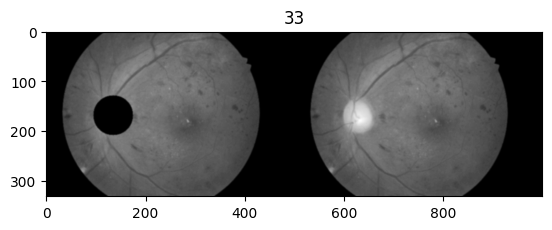

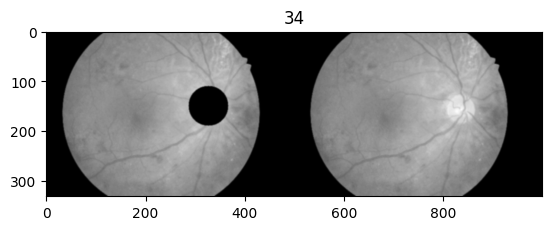

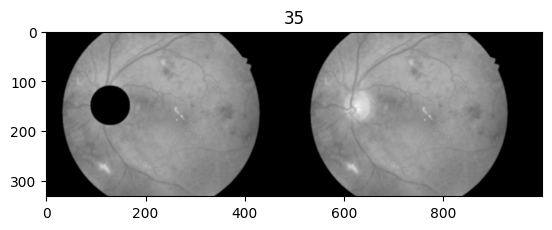

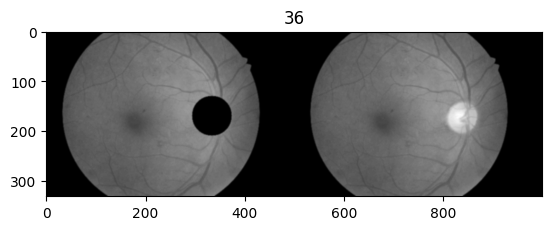

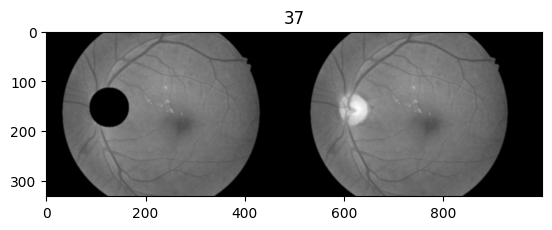

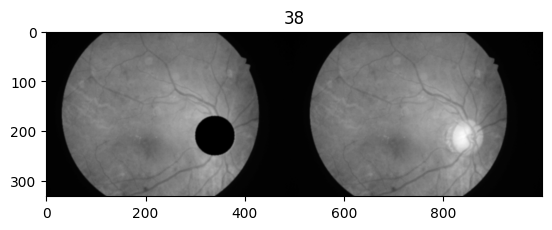

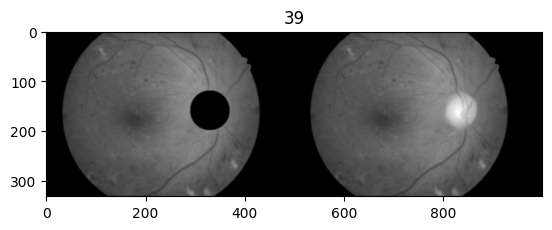

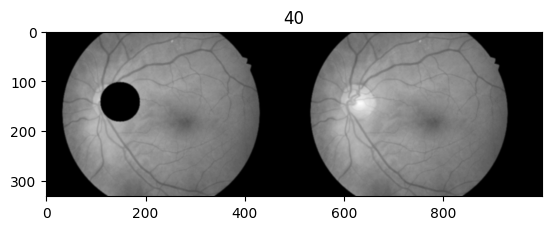

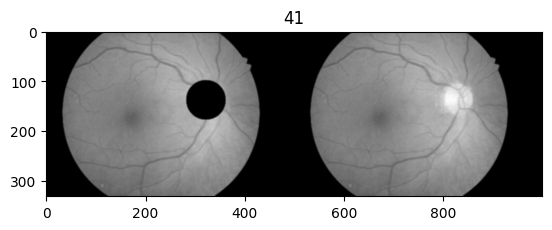

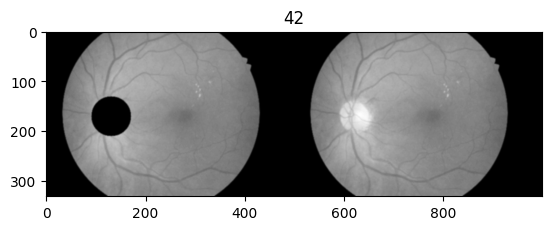

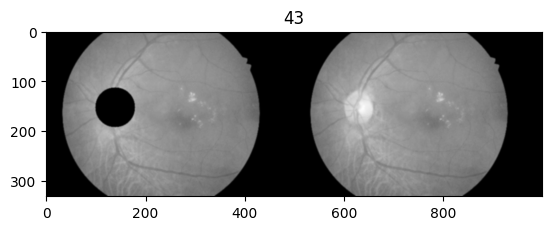

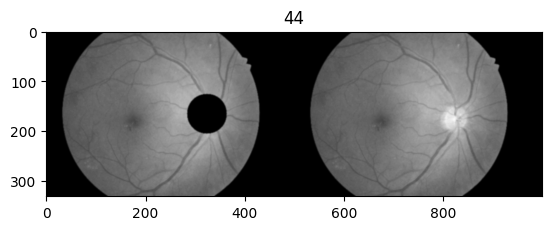

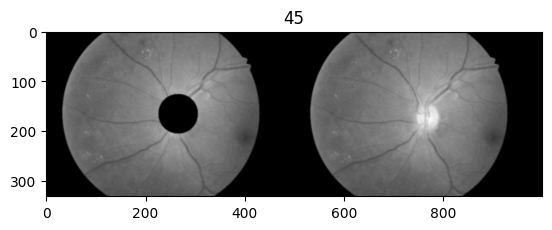

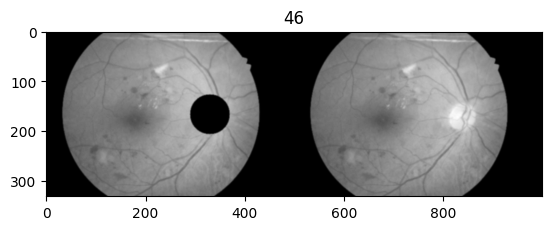

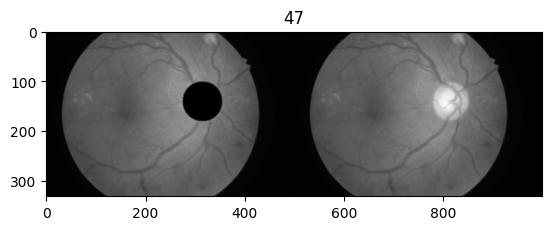

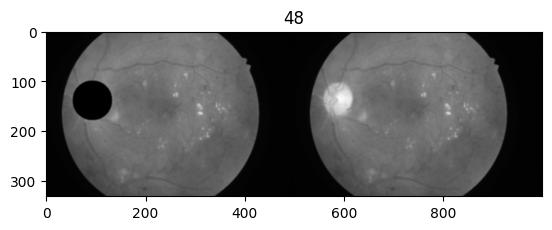

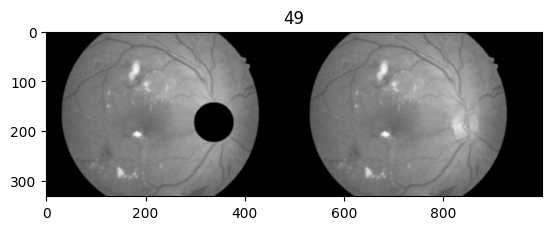

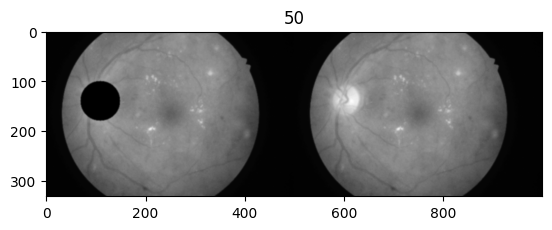

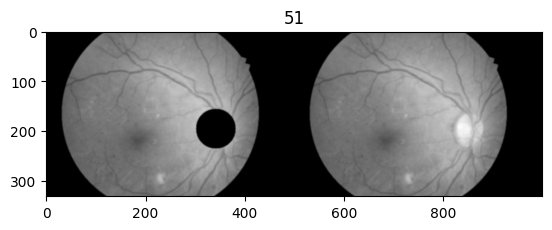

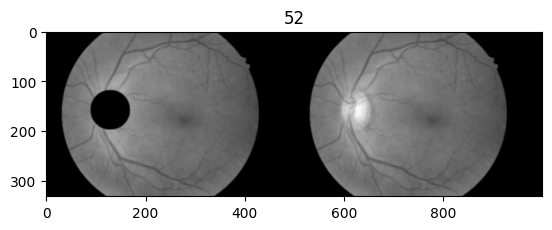

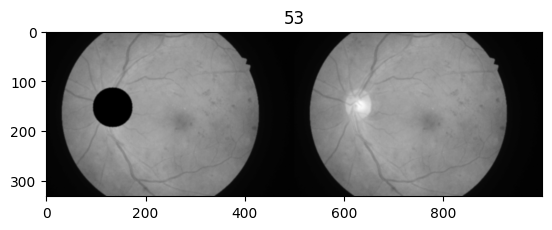

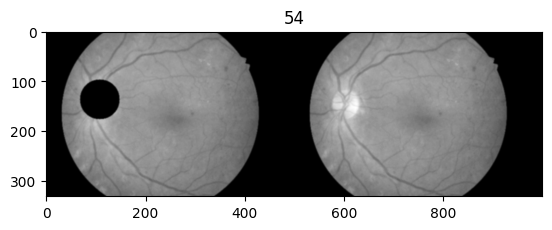

In [ ]:
#Optic Disc Localization

i = 0
count = 0
start_time = time.time()

for img_num in range(1,55):
  img = getImage(img_num)
  print("Image Number: ", img_num)

  img_rs = imgResize(img)

  img_grey = cv.cvtColor(img_rs, cv.COLOR_BGR2GRAY)


  img_k = kmeansclust(img_grey, 7, 10, 400, 0.99)


  temp = cv.imread(template_path, -1)


  #TEMPLATE MATCHING
  metd = cv.TM_CCOEFF_NORMED
  temp_mat = cv.matchTemplate(img_k, temp, metd)

  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(temp_mat)
  x = max_loc[0]+45
  y = max_loc[1]+45
  print(x,y)



  temp_mat = img_grey.copy()
  img_mark = cv.circle(temp_mat, (x, y) ,40, 0, -1)

  if (img_num<10):
    img_path = save_path + "0" + str(img_num) +'.jpg'
  else:
    img_path = save_path + str(img_num) +'.jpg'
  cv.imwrite(img_path, img_mark)

  img_stack = np.hstack([img_mark, img_grey])

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(img_stack, cmap = 'gray', interpolation = 'bicubic')



  i = i + 1

end_time = time.time()

#Hard Exudates

In [ ]:
def getContours1(img, img_main, cnt_area):
  mask1 = np.ones(img.shape, dtype="uint8") * 0
  cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_NONE)
  for i in cnts0:
    if cv.contourArea(i) <= cnt_area:
      cv.drawContours(mask1, [i], -1, 255, -1)
  mask1 = cv.bitwise_and(img_main, img_main, mask = mask1)
  return mask1

Image Number:  1
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_01.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 161789, 255: 4211}
Image Number:  2
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_02.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 164689, 255: 1311}
Image Number:  3
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_03.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 165428, 255: 572}
Image Number:  4
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_04.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 163454, 255: 2546}
Image Number:  5
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_05.jpg
(332, 500

<ipython-input-68-679d0f7147e1>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(img_num)


(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 164127, 255: 1873}
Image Number:  23
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_23.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 163136, 255: 2864}
Image Number:  24
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_24.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 164095, 255: 1905}
Image Number:  25
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_25.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 162503, 255: 3497}
Image Number:  26
/content/drive/MyDrive/DRProjectData/IDRID_Datasets/Segmentation/Original_Images/Training_Set/IDRiD_26.jpg
(332, 500) <class 'numpy.ndarray'> (332, 500) <class 'numpy.ndarray'>
{0: 164556, 255: 1444}
Image Number:  27
/content/drive/My

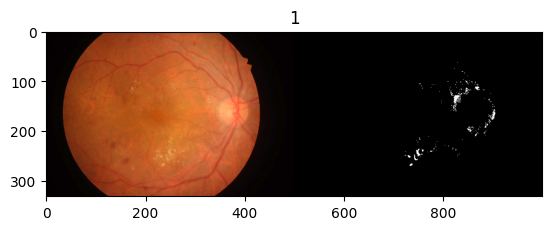

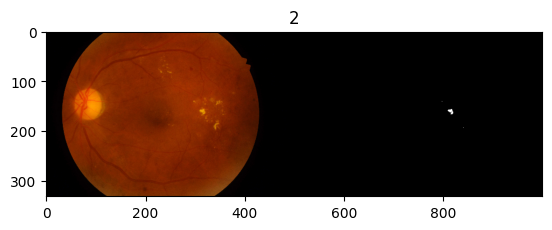

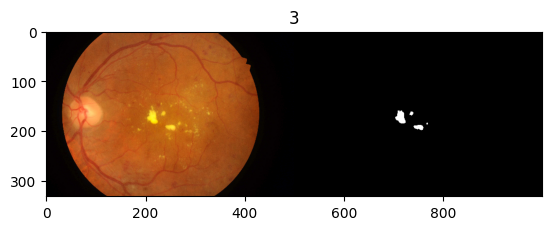

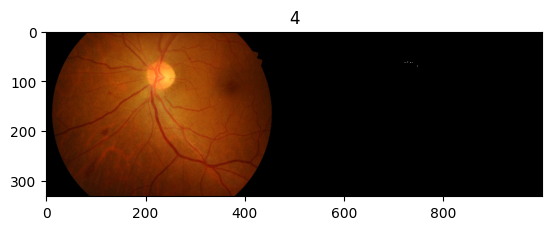

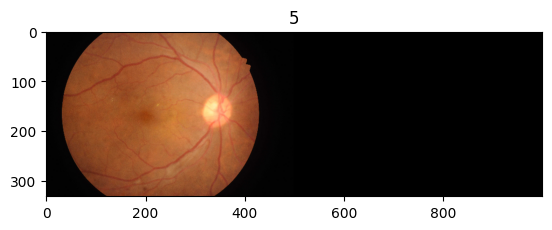

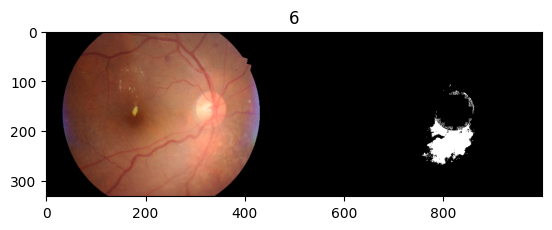

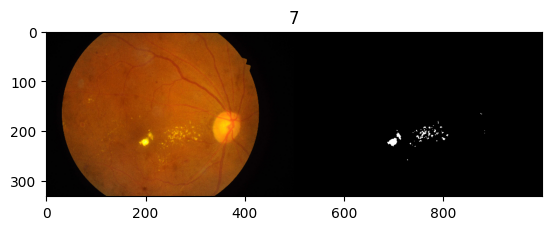

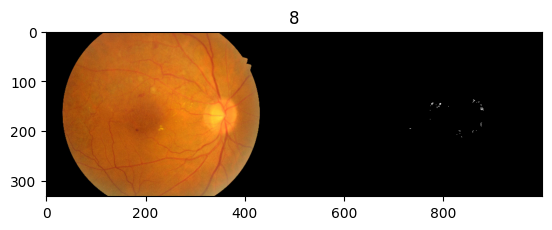

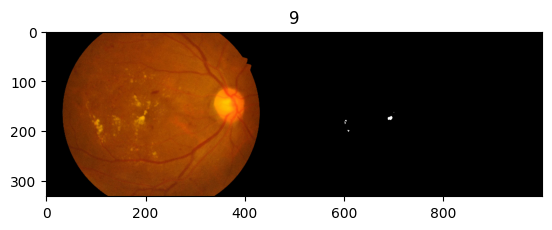

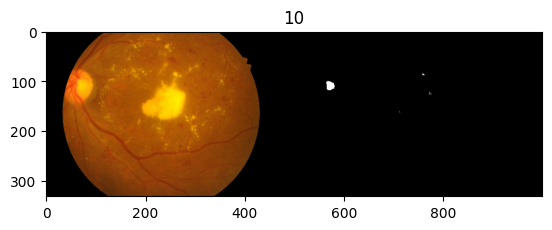

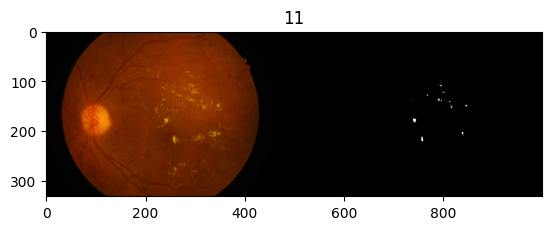

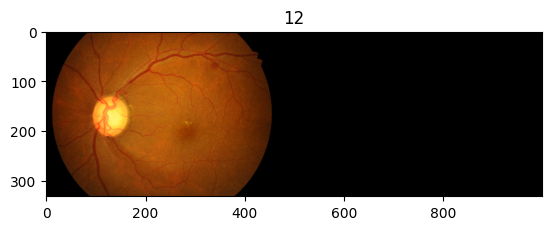

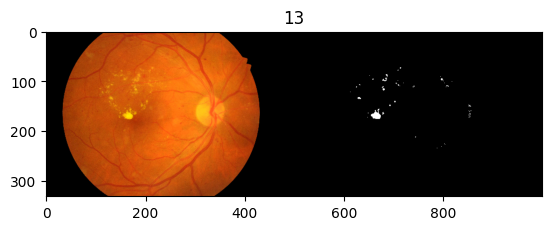

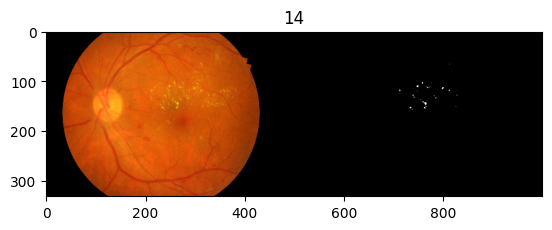

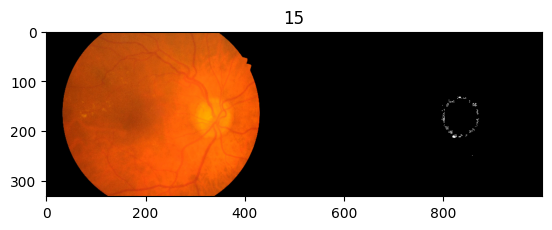

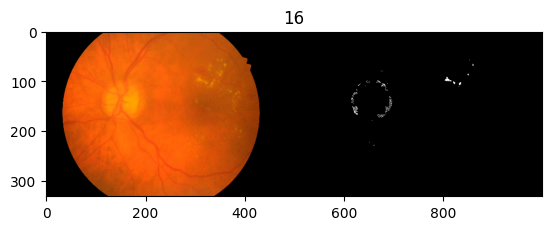

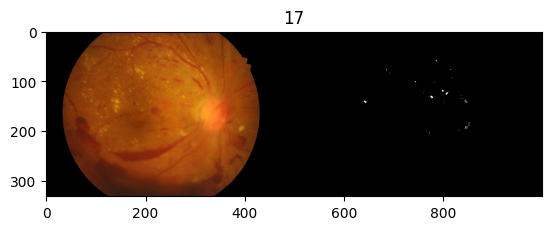

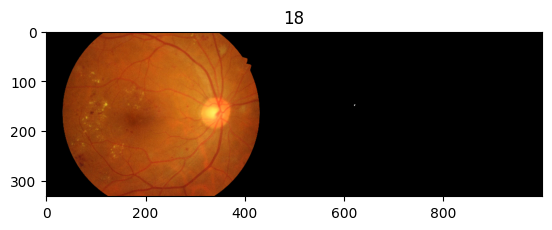

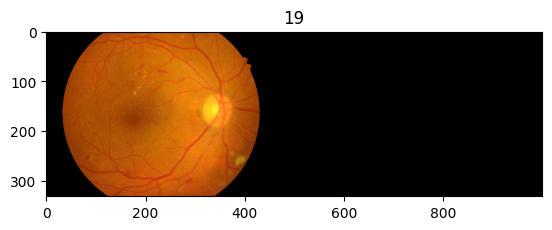

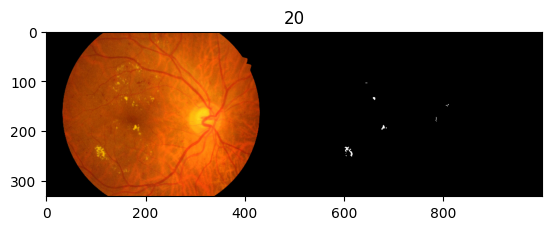

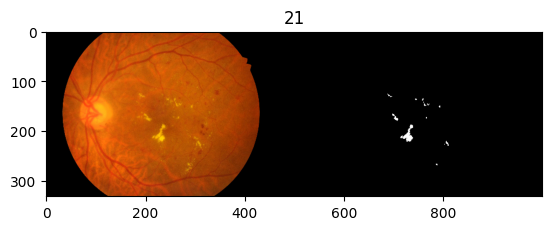

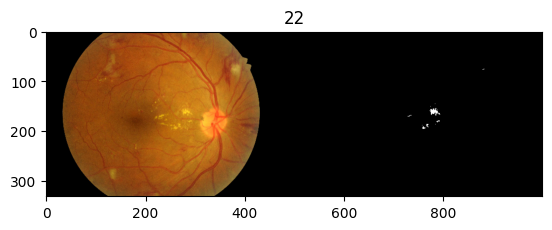

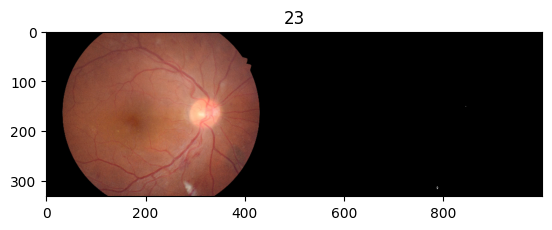

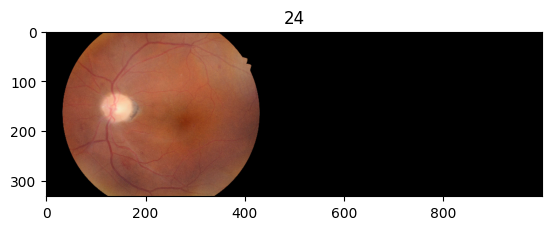

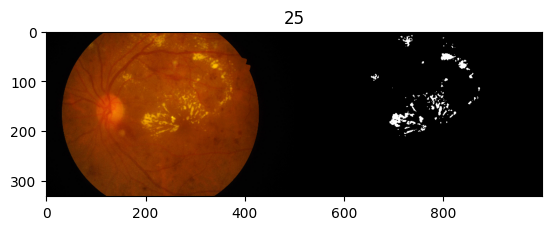

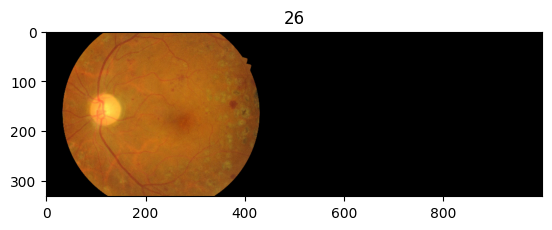

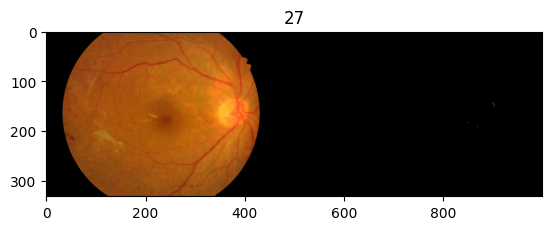

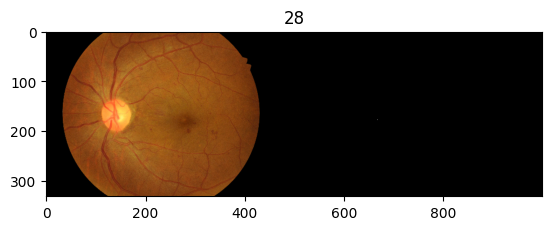

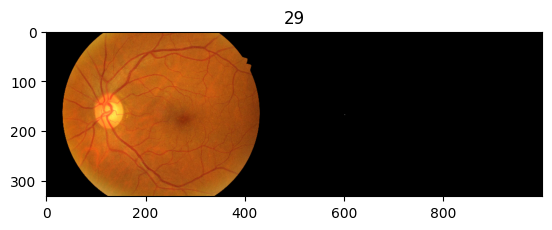

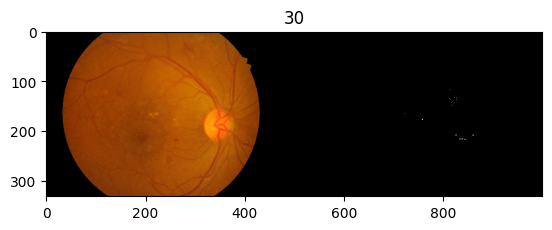

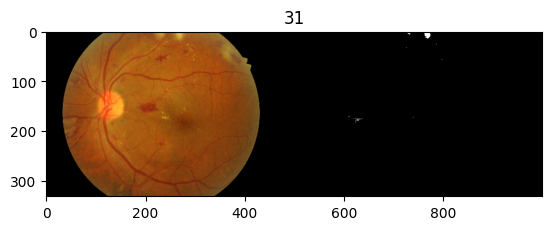

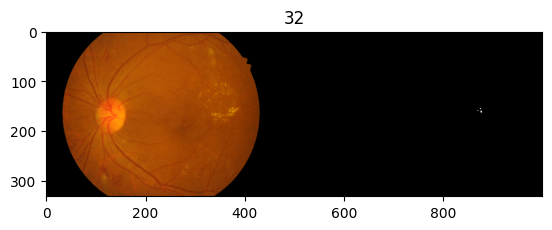

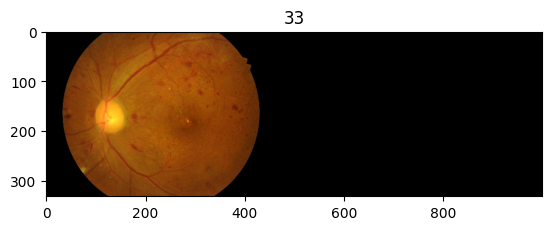

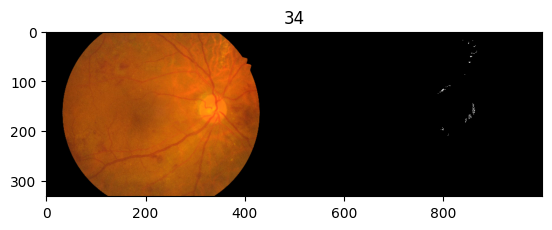

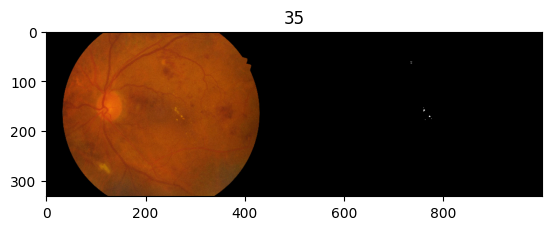

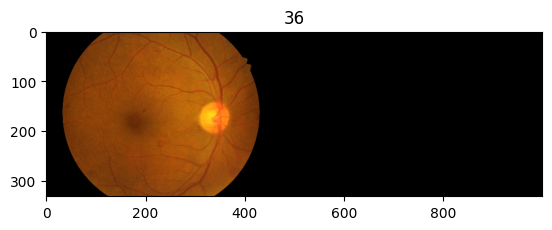

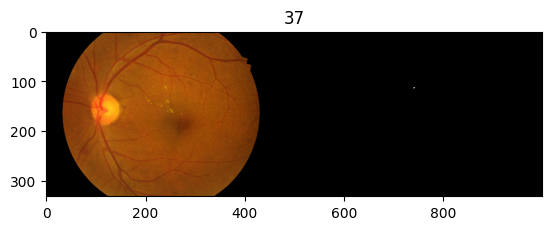

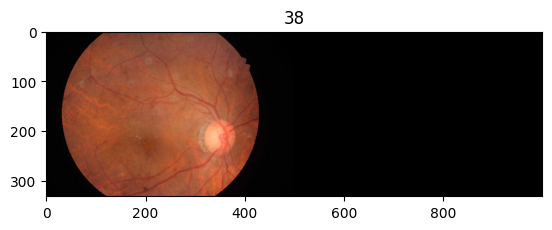

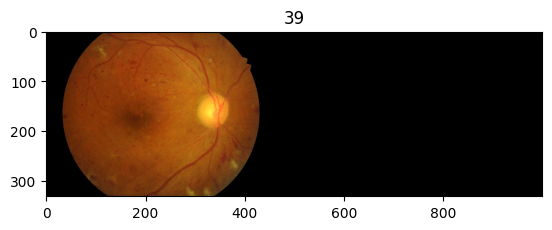

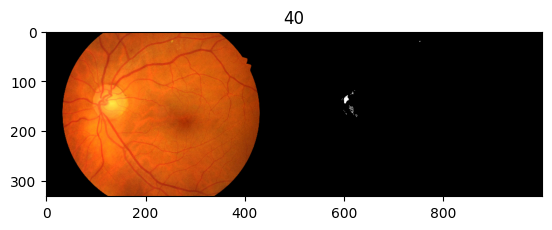

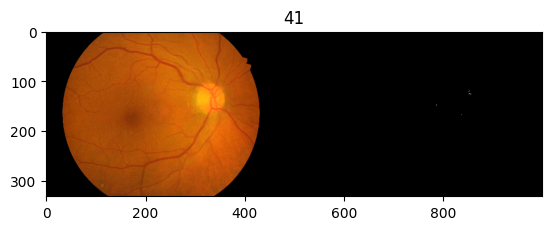

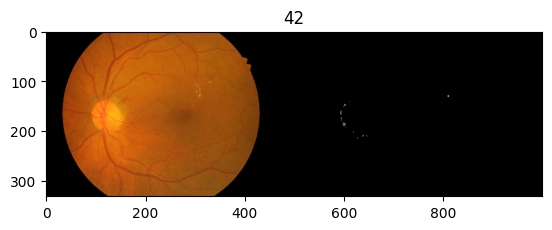

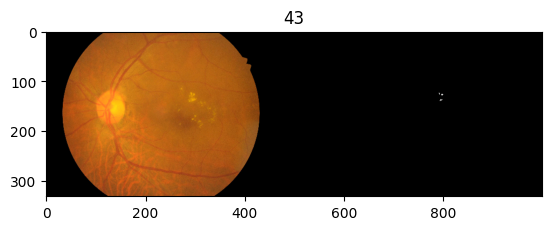

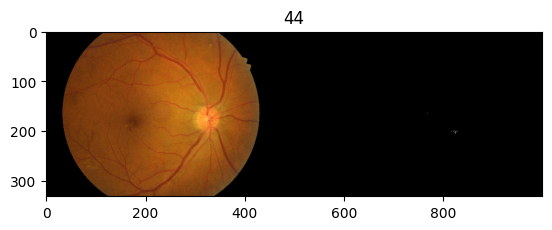

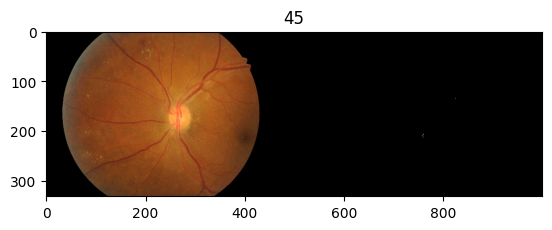

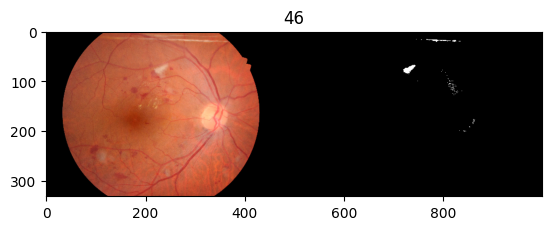

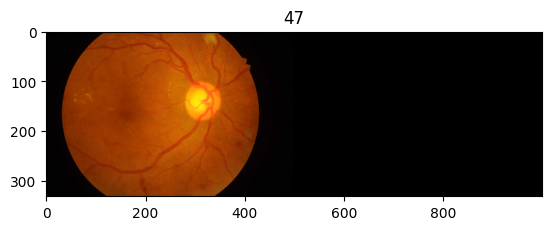

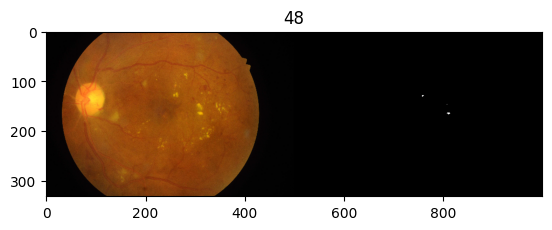

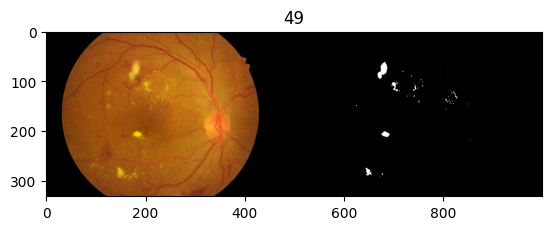

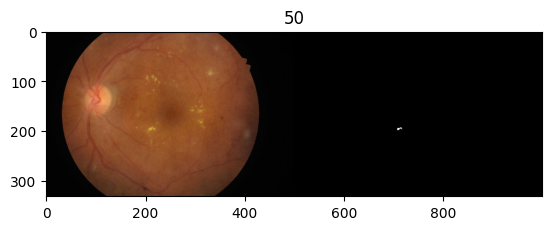

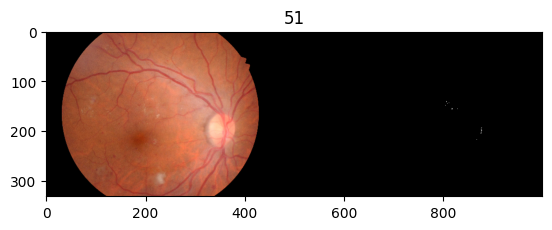

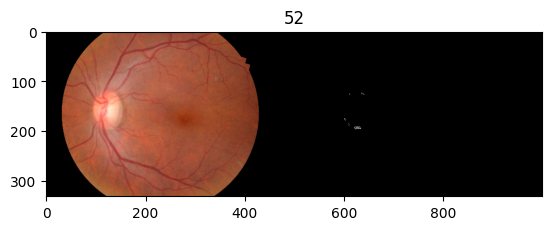

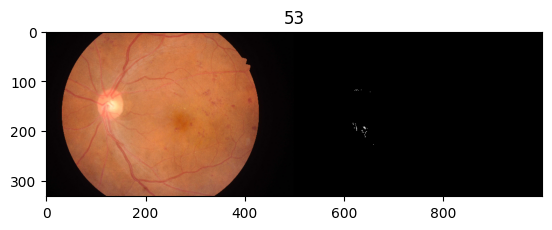

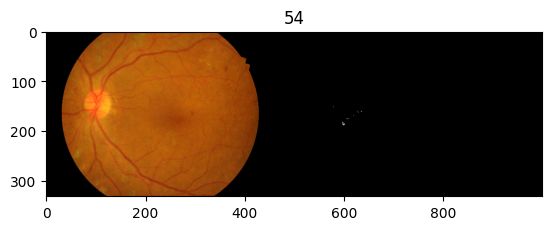

In [ ]:
#Detection of Exudates

acc = []
spcf = []
sens = []
f1_sc = []
i = 0
count = 0
img_num = 1
for img_num in range(1, 55):


  print("Image Number: ", img_num)

  if (img_num<10):
    str_num = "0" + str(img_num)
  else:
    str_num = str(img_num)
  file_path = save_path + str_num +'.jpg'
  img_mark = cv.imread(file_path, -1)



  # Read the image from file
  img = getImage(img_num)
  img = imgResize(img)


  # Splitting channels
  _, img_gc, _ = cv.split(img)


  # Large Exudates
  clus_seg = kmeansclust(img, 8, 5, 20, 0.69, use = 'EX')
  clus_seg = cv.cvtColor(clus_seg, cv.COLOR_BGR2GRAY)
  unique, counts = np.unique(clus_seg, return_counts=True)
  _,kthm = cv.threshold(clus_seg, np.max(unique)-1, 255, cv.THRESH_BINARY)


  # Small Exudates
  edges = cannyEdges(img_gc, 70, 120)
  img_cnt = cv.dilate(edges, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
  img_clean = getContours1(img_cnt, img_gc, 15)
  img_clean = cv.erode(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations=1)
  img_clean = cv.dilate(img_clean, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)), iterations = 2)
  max_intsy = np.max(img_clean.flatten())
  img_clean[img_clean>=max_intsy] = 255
  img_clean[img_clean<max_intsy] = 0
  _, img_clean = cv.threshold(img_clean, 173, 255, cv.THRESH_BINARY)


  img_final = cv.bitwise_or(kthm, img_clean)

  #Masking Optic Disc
  img_final[img_mark==0] = 0

  plt.figure(img_num)
  plt.title(img_num)
  plt.imshow(np.hstack([cv.cvtColor(img, cv.COLOR_RGB2BGR), cv.cvtColor(img_final, cv.COLOR_GRAY2BGR)]))